# Final Project - K q-flats

---

90498 - Machine Learning

Laurea Magistrale - Computer science

Artificial Intelligence Track

University of Genova

---

Proffessors:

- Nicoletta Noceti

- Lorenzo Rosasco

---

Student:

- Arnaud Ruymaekers - S5298338

## 0) Index

1. Introduction

    1.1. Motivation

    1.2. Method Description
    
    1.3. Imports and Tool Function
    
    1.4. Synthetic data generation

2. Method construction

3. Comparisson of method on different data sets

4. Conclusions

5. Sources

## 1) Introduction

### 1.1) Motivation

- For my project choices, I wanted to go for a project about Clustering as this topic really peaked my interest.

- I was attracted to k-flats in particular because I was interested in discovering how data generated in certain shapes could be clusterized in a more accurate manner that with k-means.

- I was interested by a generalization of the k-means algorithm as data, in real life, comes in widely different shapes that simple blobs of points.

### 1.2) Method description

- While researching, it came to my attention that this technique is called by different names while refering to the same:
    
    - k-flats
    
    - k q-flat
    
    - k-planes
    
- The algorithm has been developped by P.S. Bradley and O.L. Mangasarian in the early 2000's. It is based on their descriptions that I will implement the algorithm.

- The algorithm is a generalization of the k-means Lloyd  algorithm. Like the Lloyd algorithm, it consists of a cluster assignment phase and a cluster update phase. Unlike with the k-means algorithm the find the centers of clusters, the k q-flats algorithm finds the q-dimensional hyperplanes minimizing the square distance to the points assigned to this hyperplace.

- For instance when $q=0$ the algorithm is k-means, when $q=1$ the hyperplanes are lines, when $q=2$ the hyperplanes are planes in 3d and so forth...




- Hyperplane definition: $P_l = \{ x | x \in R^n , x' w_l = \gamma_l \}$ for each $l=1...k$

- *Cluster assignment*: At each iteration j and for each point i: $\min_{l=1...k}\| A_i w_l^j - \gamma_l^j \|$

- *Cluster update*:

    - $A(l)$ are all the data points assigned to cluster l. $e$ is a vector of ones.
    
    - $w_l^{j+1}$ is the eigenvector corresponding to the smallest eigenvalue of the matrix defined by: $B(l) = \left[A(l)\right]' \left(I - \frac{e e'}{m(l)}\right)$ where $m(l)$ is the amount of point assigned to cluster l.
    
    - $\gamma_l^{j+1} = \frac{e' A(l) w_l^{j+1}}{m(l)}$

### 1.3) Imports and Tool functions

In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

In [2]:
def gen_blob(n, sigma):
    '''
    Method to generate n data point uniformly with some Gaussian noise having standard deviation of sigma.
    '''
    return np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2) * sigma ** 2, size=n)

In [3]:
def gen_poly(n, d, coefs, min_X, max_X, sigma):
    '''
    Method to generate n data points uniformly following the polynomial of dimension d defined by the coefficients coef in the interval [min_X;max_X]
    Some Gaussian noise with standard deviation of sigma is then added to the data.
    '''
    assert len(coefs) == d+1
    
    X = np.random.uniform(min_X, max_X, size=(n, 1))
    X_1 = np.array([np.zeros(n)]).T
    for i in range(d+1):
        X_1 += coefs[i] * (X**i)
        
    X_1 += np.random.normal(0, sigma, size=(n, 1))
    
    return np.concatenate((X, X_1), axis=1)

In [4]:
def gen_circle(n, r, sigma):
    '''
    Method to generate n data points uniformly around a circle of radius r with some added Gaussian noise with standard deviation sigma.
    '''
    pi_range = np.random.uniform(0, 2*np.pi, size=(n, 1))
    X = np.concatenate((np.cos(pi_range), np.sin(pi_range)), axis=1)
    X *= r
    X += np.random.normal(0, sigma, size=(n, 1))
    return X

In [5]:
def assignment_accuracy(Y, predicted_Y):
    '''
    Method to compute the accuracy of a predicted cluster assignment versus the source cluster assignmnent.
    Adapted from https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/
    '''
    cm = confusion_matrix(Y, predicted_Y)
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)

    indexes = linear_sum_assignment(_make_cost_m(cm))
    js = [e[1] for e in sorted(list(zip(*indexes)), key=lambda x: x[0])]
    cm2 = cm[:, js]
    return np.trace(cm2) / np.sum(cm2)

In [126]:
def random_planes_gen(k, q, scale):
    '''
    Method to generate k random coefficient vectors with norm of 1 along with a random gamma. 
    '''
    rng = np.random.default_rng()
    rd_gen = rng.random((k,q+2)) * scale

    rd_gen[:,:2] /= np.array([np.linalg.norm(rd_gen[:,:2], axis=1)]).T
    return rd_gen

### 1.4) Synthetic data generation

For this project, we will generate different types of systhetic datasets to asses k q-flats algorithm on.

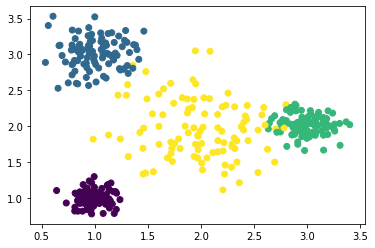

In [6]:
# Regular blobs
n = 100
centers = [(1,1), (1,3), (3,2), (2,2)]
sigmas = [0.1, 0.2, 0.15, 0.4]

c_X = None

for i, center in enumerate(centers):
    class_label = (np.array([np.ones(n)]) * i).T
    X = gen_blob(n, sigmas[i]) + np.array(center)
    c_X_i = np.concatenate((X, class_label), axis=1)
    
    c_X = c_X_i if c_X is None else np.concatenate((c_X, c_X_i))
    
np.random.shuffle(c_X)    

X, Y = c_X[:, :2], c_X[:,2]

blob_data = c_X

plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

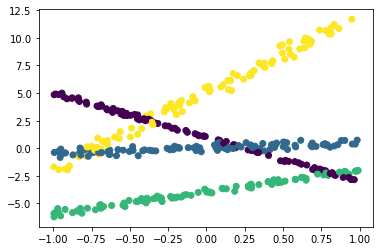

In [44]:
# Lines
n = 100
slopes = [-4, 0.5, 2, 7]
sigmas = [0.1, 0.2, 0.15, 0.4]
shifts = np.array([(0,1),(0,0),(0,-4),(0,5)])

c_X = None

for i, slope in enumerate(slopes):
    class_label = (np.array([np.ones(n)]) * i).T
    X = gen_poly(n, 1, (0, slope), -1, 1, sigmas[i])
    X += shifts[i]
    c_X_i = np.concatenate((X, class_label), axis=1)
    
    c_X = c_X_i if c_X is None else np.concatenate((c_X, c_X_i))
    
np.random.shuffle(c_X)  

X, Y = c_X[:, :2], c_X[:,2]

line_data = c_X

plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

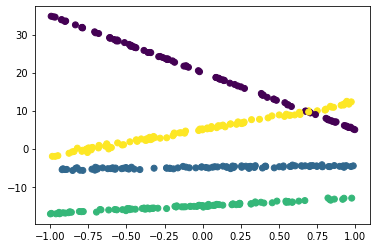

In [104]:
# Lines Split
n = 100
slopes = [-15, 0.5, 2, 7]
sigmas = [0.1, 0.2, 0.15, 0.4]
shifts = np.array([(0,20),(0,-5),(0,-15),(0,5)])

c_X = None

for i, slope in enumerate(slopes):
    class_label = (np.array([np.ones(n)]) * i).T
    X = gen_poly(n, 1, (0, slope), -1, 1, sigmas[i])
    X += shifts[i]
    c_X_i = np.concatenate((X, class_label), axis=1)
    
    c_X = c_X_i if c_X is None else np.concatenate((c_X, c_X_i))
    
np.random.shuffle(c_X)  

X, Y = c_X[:, :2], c_X[:,2]

line_data_split = c_X

plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

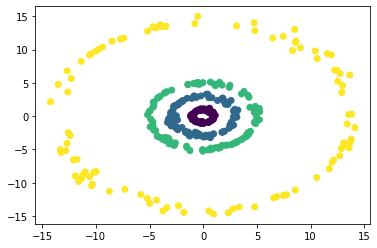

In [8]:
# Concentric circles
n = 100
rs = [1,3,5,14]
sigmas = [0.1, 0.2, 0.15, 0.5]

c_X = None

for i, r in enumerate(rs):
    class_label = (np.array([np.ones(n)]) * i).T
    X = gen_circle(n, r, sigmas[i])
    c_X_i = np.concatenate((X, class_label), axis=1)
    
    c_X = c_X_i if c_X is None else np.concatenate((c_X, c_X_i))
    
np.random.shuffle(c_X)

X, Y = c_X[:, :2], c_X[:,2]

circles_data = c_X

plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

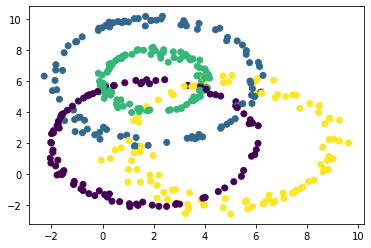

In [9]:
# Multiple shifted circles
# Concentric circles
n = 100
rs = [4,4,2,4]
centers = [(2,2), (2,6), (2,6), (5,2)]
sigmas = [0.1, 0.2, 0.15, 0.3]

c_X = None

for i, r in enumerate(rs):
    class_label = (np.array([np.ones(n)]) * i).T
    X = gen_circle(n, r, sigmas[i])
    X += np.array(centers[i])
    c_X_i = np.concatenate((X, class_label), axis=1)
    
    c_X = c_X_i if c_X is None else np.concatenate((c_X, c_X_i))
    
np.random.shuffle(c_X)

X, Y = c_X[:, :2], c_X[:,2]

circles_async_data = c_X

plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

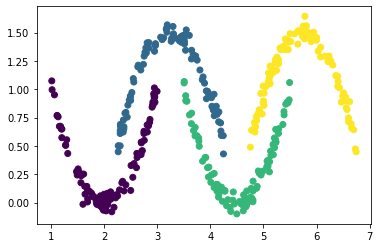

In [10]:
# U's
n = 100
coefs = [1,-1,1,-1]
centers = [(2,0), (3.25,1.5), (4.5,0), (5.75,1.5)]
sigmas = [0.05, 0.05, 0.05, 0.05]

c_X = None

for i, coef in enumerate(coefs):
    class_label = (np.array([np.ones(n)]) * i).T
    X = gen_poly(n, 2, (0, 0, coef), -1, 1, sigmas[i])
    X += np.array(centers[i])
    c_X_i = np.concatenate((X, class_label), axis=1)
    
    c_X = c_X_i if c_X is None else np.concatenate((c_X, c_X_i))
    
np.random.shuffle(c_X)  

X, Y = c_X[:, :2], c_X[:,2]

u_data = c_X

plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

## 2) Method construction

In [11]:
def lloyd(X, centers, maxiter):
    # X: n x d
    # centers : k x d
    n, d = X.shape
    k = centers.shape[0]
    
    centers = centers.astype('float')
    
    for i in range(maxiter):
        # Compute Squared Euclidean distance (i.e. the squared distance)
        # between each cluster centre and each observation
        dist = distance.cdist(X, centers, metric='sqeuclidean')
        
        # Assign data to clusters: 
        # for each point, find the closest center in terms of euclidean distance
        c_asg = np.argmin(dist, axis=1)

        # Update cluster center
        for c in range(k):
            centers[c] = np.mean(X[c_asg == c], axis=0)
        
    return c_asg, centers

In [149]:
def lloyd_k_q_flats(X, q, planes, maxiter):
    # X: n x q
    # planes : k x (q+2)
    n, d = X.shape
    k = planes.shape[0]
    
    planes = planes.astype('float')
    
    if q==0:
        print('q=0, proceeding to processing k-means')
        # K-means
        return lloyd(X, planes, maxiter)
    
    X = np.fliplr(X)
    w = planes[:,:-1]
    gamma = planes[:,-1]
    
    for i in range(maxiter):
        # Computation of the distances:
        dist = np.abs(np.matmul(X, w.T) + gamma)
        
        # Assign data to clusters: 
        c_asg = np.argmin(dist, axis=1)

        # Update cluster planes
        w_new = np.zeros(w.shape)
        gamma_new = np.zeros(gamma.shape)
        for l in range(k):
            Al = X[c_asg == l]
            ml = Al.shape[0]
            
            # Set w+1
            mat = np.matmul(np.matmul(Al.T, (np.eye(ml) - (np.ones((ml,ml)) / ml))), Al)
            eig_vals, eig_vects = np.linalg.eig(mat)
            w_new[l] = eig_vects[:,np.argmin(eig_vals)]
            
            # Set gamma+1
            gamma_new[l] = - np.matmul(np.matmul(np.ones((1,ml)), Al), w_new[l]) / ml
        
        w = w_new
        gamma = gamma_new

    planes = np.concatenate((w, np.array([gamma]).T), axis=1)
        
    return c_asg, planes

## 3) Comparing the method on the different datasets

#### Blob data

q=0, proceeding to processing k-means
Cluster assignment accuracy 94.50%


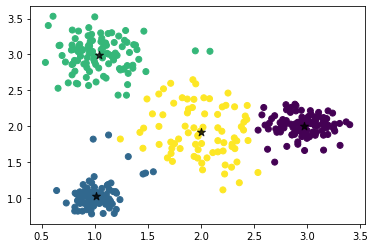

In [20]:
'''
Blobs
'''
# Data and variables
X, Y = blob_data[:,:-1], blob_data[:,-1]
q = 0
k=4

# Initial planes
planes = np.random.uniform(low=np.amin(X, 0), high=np.amax(X, 0), size=(k, X.shape[1]))

# Clustering
c_asg, centers = lloyd_k_q_flats(X, q, planes, 10)

# Accuracy
acc = assignment_accuracy(Y, c_asg)
print(f'Cluster assignment accuracy {acc*100:.2f}%')

# Plotting
plt.scatter(X[:,0], X[:,1], c=c_asg)
plt.scatter(centers[:,0], centers[:,1], s=70, marker='*', c='k', alpha=0.8)
plt.show()

#### Observations:

- As expected, the k q-fold algorithm performs well on data coming as blobs as with q=0, it acts just like k-means.

---

#### Line data

q=0, proceeding to processing k-means
Cluster assignment accuracy 63.50%


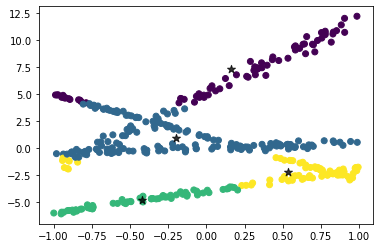

In [21]:
'''
Lines with k-means
'''
# Data and variables
X, Y = line_data[:,:-1], line_data[:,-1]
q = 0
k=4

# Initial planes
planes = np.random.uniform(low=np.amin(X, 0), high=np.amax(X, 0), size=(k, X.shape[1]))

# Clustering
c_asg, centers = lloyd_k_q_flats(X, q, planes, 10)

# Accuracy
acc = assignment_accuracy(Y, c_asg)
print(f'Cluster assignment accuracy {acc*100:.2f}%')

# Plotting
plt.scatter(X[:,0], X[:,1], c=c_asg)
plt.scatter(centers[:,0], centers[:,1], s=70, marker='*', c='k', alpha=0.8)
plt.show()

#### Observations:

- As expected, when trying to cluster lines with k-means, the accuracy is pretty poor.

Cluster assignment accuracy 90.50%


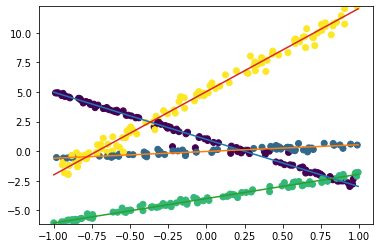

In [22]:
'''
Lines with q=1 with initial lines coefs
'''
# Data and variables
X, Y = line_data[:,:-1], line_data[:,-1]
q = 1
k=4

# Initial planes
planes = np.array([[1,4,-1], [1,-0.5,0], [1,-2,4], [1,-7,-5]])

# Clustering
c_asg, planes = lloyd_k_q_flats(X, q, planes, 10)

# Accuracy
acc = assignment_accuracy(Y, c_asg)
print(f'Cluster assignment accuracy {acc*100:.2f}%')

# Plotting
plt.scatter(X[:,0], X[:,1], c=c_asg)
plt.ylim(min(X[:,1]),max(X[:,1]))
for i in range(4):
    line_x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 100)
    slope = planes[i][1]/planes[i][0]
    c = planes[i][2]/planes[i][0]
    line_y = (-slope * line_x) - c
    plt.plot(line_x,line_y)
plt.show()

Cluster assignment accuracy 73.00%


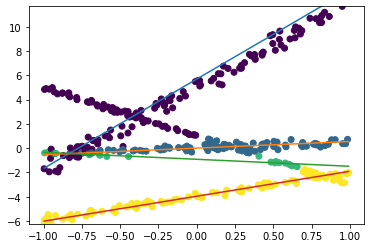

In [137]:
'''
Lines with q=1
'''
# Data and variables
X, Y = line_data[:,:-1], line_data[:,-1]
q = 1
k=4

# Initial planes
planes = random_planes_gen(k, q, 2)

# Clustering
c_asg, planes = lloyd_k_q_flats(X, q, planes, 100)

# Accuracy
acc = assignment_accuracy(Y, c_asg)
print(f'Cluster assignment accuracy {acc*100:.2f}%')

# Plotting
plt.scatter(X[:,0], X[:,1], c=c_asg)
plt.ylim(min(X[:,1]),max(X[:,1]))
for i in range(4):
    line_x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 100)
    slope = planes[i][1]/planes[i][0]
    c = planes[i][2]/planes[i][0]
    line_y = (-slope * line_x) - c
    plt.plot(line_x,line_y)
plt.show()

#### Observations:

- When setting q=1, I demonstrated there that the algorithm is working and stable by setting the the initial planes with the coefficients the lines were initially built with.

- With randomly generated lines, we can see that the algorithm manages to pick up some lines each time it run but find all the initial line happened only once during my testing.

---

#### Split lines data

Cluster assignment accuracy 93.00%


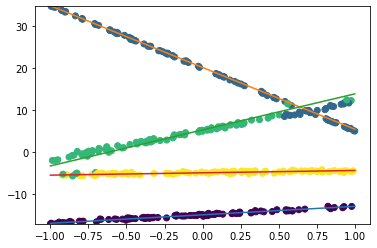

In [141]:
'''
Lines with q=1
'''
# Data and variables
X, Y = line_data_split[:,:-1], line_data_split[:,-1]
q = 1
k=4

# Initial planes
planes = random_planes_gen(k, q, 10)

# Clustering
c_asg, planes = lloyd_k_q_flats(X, q, planes, 10)

# Accuracy
acc = assignment_accuracy(Y, c_asg)
print(f'Cluster assignment accuracy {acc*100:.2f}%')

# Plotting
plt.scatter(X[:,0], X[:,1], c=c_asg)
plt.ylim(min(X[:,1]),max(X[:,1]))
for i in range(4):
    line_x = np.linspace(np.min(X[:,0]), np.max(X[:,0]), 100)
    slope = planes[i][1]/planes[i][0]
    c = planes[i][2]/planes[i][0]
    line_y = (-slope * line_x) - c
    plt.plot(line_x,line_y)
plt.show()

#### Observations:

- With a data set of coming based on line data more spread appart, the algorithm finds the original lines most of the runs I tried. Also it has to be noted that the initial planes generated have a scaled gamma component so that the lines are more spread over the Y direction.

---

#### Line and circle data

- To solve the data clustering problem for Circluarly generated or Quadratically generated data, we would need to setup feature maps to allow non-linear data to be processed. This could be a path for future investigation.

## 4) Conclusions

- After developping the k q-fold algorithm, we can see that, very much like k-means, it struggles to find the true center/initial when the data overlaps together. But when the data has minimal overlap it performs very relatively well.

- Other similarity with k-means, the algorithm depends a lot on the initial randomized setting of the centers/lines/hyperplanes. This means that often to get a satisfactory result, the algorithm had to be run multiple times.

- Here, the 3D data has not been generated but very much like 2D lines, as long as the planes along which the data points are generated don't overlap too much and is not too noisy, the algorithm will perform reasonably well.

## 5) Sources

- https://en.wikipedia.org/wiki/K_q-flats

- https://towardsdatascience.com/the-anatomy-of-k-means-c22340543397

- https://minds.wisconsin.edu/bitstream/handle/1793/66118/98-08.pdf?sequence=1&isAllowed=y

- https://sparse-plex.readthedocs.io/en/latest/book/subspace_clustering/alg_k_plane.html

- https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/#:~:text=Computing%20accuracy%20for%20clustering%20can,the%20accuracy%20for%20clustering%20results.